In [6]:
# Privacy imports
from diffprivlib.mechanisms import exponential
from diffprivlib.mechanisms import laplace as diffpriv_laplace
from mechanisms import *


# Tooling imports
import numpy as np 
import pandas as pd
import argparse
import math
np.seterr(divide='ignore', invalid='ignore')
from scipy import optimize 
from scipy.interpolate import make_interp_spline, BSpline
import scipy.integrate as integrate
from scipy.stats import laplace
from scipy.integrate import quad
import scipy.special as special
from scipy.special import logsumexp
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import statistics
import csv
import pickle


# For plotting colors imports
from matplotlib.pyplot import cm

In [7]:
def reset_color_iterator():

    return iter(["cyan", "magenta", "red", "orange", "green", "blue", "indigo", "darkgray", "dimgray", "black"])
color = reset_color_iterator()

In [2]:
def worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, num_categories, p=0, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    This function implements Equation 7 of the publication found: https://arxiv.org/abs/2010.12603
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float, optional
        Heads probability in randomized response
        
    num_true_categories: int, optional
        Number of categories that are in the bounding interval    
    """  
    
    return (2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    
def worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, num_categories, p=0, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    This function implements Equation 8 of the publication found: https://arxiv.org/abs/2010.12603
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float, optional
        Heads probability in randomized response
    
    num_true_categories: int, optional
        Number of categories that are in the bounding interval
    """  
    return (2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - (1-(1-worst_case_probability)**(num_categories))/(worst_case_probability*num_categories))
    
def worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    It is a modification of equation 7 of the publication found:  https://arxiv.org/abs/2010.12603, so that
    it adapts to enhanced randomized response.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float
        Heads probability in randomized response
        
    num_true_categories: int
        Number of categories that are in the bounding interval
    """  

    a = (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    b = (2 * sensitivity / epsilon) * (p/num_true_categories) * (num_true_categories - 1) * np.log(1/worst_case_probability)
    return a + b 

In [3]:
def worst_case_expected_error_noisy_max(c, epsilon, n=2):
    r"""
        Executes the worst case expected error of noisy max
        
    Parameters
    ----------   
    c: float
        The value of the utility function, which are the same for all categories.
        
    n: int
        Number of categories which share the same utility value (-1)

    """       
    lap = laplace(loc=0, scale=2.0/epsilon) #Modified
    foo = lambda z: lap.pdf(z)*lap.cdf(z-c)**(n-1)
    star = quad(foo, a=-np.inf, b=np.inf)[0]
    return 0-(1-star)*c

In [4]:
def expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, c_vector, num_categories, p_values, p_index, num_categories_list, num_true_categories=1):
    r"""
        Executes the experiments
        
    Parameters
    ----------
    epsilon : float
        Privacy paramete

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
    
    c_vector: list of floats
        The values of the utility functions, which are the same for all categories.
        
    num_categories: int
        Number of categories which share the same utility value (-1)
        
    p_values: list of floats
        List of heads probabilities of randomized response
    """      
    expected_errors_dict = defaultdict(list)
    expected_error_ratios_em_err = defaultdict(list)
    expected_error_ratios_pf_err = defaultdict(list)
    
    # Initializing lists
    expected_errors_dict[r'$\mathcal{M}_{EM}$'] = []
    expected_errors_dict[r'$\mathcal{M}_{PF}$'] = []
#     expected_errors_dict[r'$\mathcal{M}_{NM}$'] = []
    for p in p_values:

        expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)] = []
    
    # Obtaining the analytical values
    for c in c_vector:
        
        worst_case_probability = np.exp(epsilon * c / 2 / sensitivity)
        
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, num_categories))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, num_categories))
#         expected_errors_dict[r'$\mathcal{M}_{NM}$'].append(worst_case_expected_error_noisy_max(c, epsilon, num_categories))
        
        if abs(c) <= sensitivity:
            num_true_categories = num_categories
        else:
            num_true_categories = 1
                
        for p in p_values: 
            
            expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p, num_true_categories))
    
        # RATIOS OF EXPECTED ERROR
    for n in num_categories_list:

        temp_list_expected_errors_EM = []
        temp_list_expected_errors_PF = []
        temp_list_expected_errors_ERR = []
        
        for c in c_vector:
            
            if abs(c) <= sensitivity:
                num_true_categories = num_categories
            else:
                num_true_categories = 1
            
            worst_case_probability = np.exp(epsilon * c / 2 / sensitivity)
            
            temp_list_expected_errors_EM.append(worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, n))
            temp_list_expected_errors_PF.append(worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, n))
            temp_list_expected_errors_ERR.append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, n, p_values[p_index], num_true_categories))
        
        expected_error_ratios_em_err['n={}'.format(n)] = [em / err for em, err in zip(temp_list_expected_errors_EM, temp_list_expected_errors_ERR)]
        #expected_error_ratios_em_err['EM/ERR (n={})'.format(n)] = [em / err for em, err in zip(temp_list_expected_errors_EM, temp_list_expected_errors_PF)]

        expected_error_ratios_pf_err['n={}'.format(n)] = [pf / err for pf, err in zip(temp_list_expected_errors_PF, temp_list_expected_errors_ERR)]
   
    
    plotting_expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, num_categories, c_vector, expected_errors_dict, expected_error_ratios_em_err, expected_error_ratios_pf_err, num_categories_list, p_values, p_index, num_true_categories)


In [412]:
def plotting_expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, num_categories, c_vector, expected_errors_dict, expected_error_ratios_em_err, expected_error_ratios_pf_err, num_categories_list, p_values, p_index, num_true_categories):
    r"""
        Plots the experiments results
        
    Parameters
    ----------
    epsilon : float
        Privacy paramete

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
    
    num_categories: int
        Number of categories which share the same utility value (-1)
        
    c_vector: list of floats
        The values of the utility functions, which are the same for all categories.    
    
    expected_errors_dict: dictionary 
        Contains  the expected errors of each mechanism
    """       
    x = c_vector
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(18.5, 10.5)
    
    for key, values in expected_errors_dict.items():
    
        if key == r'$\mathcal{M}_{PF}$':
            continue
    
        axs[0, 0].plot(x, values, label=key)
    
        axs[0, 0].set_title('(\u03B5={}, n={})'.format(epsilon, num_categories), fontsize=23)                   
    
    axs[0, 0].legend(loc=2, ncol=1, fontsize=20)
    
    axs[0, 0].set(xlabel='$\\nu$', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    
    for key, values in expected_errors_dict.items():
    
        if key == r'$\mathcal{M}_{EM}$':
            continue
    
        axs[0, 1].plot(x, values, label=key)
    
        axs[0, 1].set_title('(\u03B5={}, n={})'.format(epsilon, num_categories), fontsize=23)                   
    
    axs[0, 1].legend(loc=2, ncol=1, fontsize=20)
    
    axs[0, 1].set(xlabel='$\\nu$', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')

        # Now we plot the ratios
    for key, ratios in expected_error_ratios_em_err.items():

        axs[1, 0].plot(x, ratios, label=key)
        axs[1, 0].set_title('(p={}, \u03B5={}, \u0394={})'.format(p_values[p_index], epsilon, sensitivity), fontsize=23)#, num_true_categories))        

    axs[1, 0].legend(ncol=2, fontsize=20)
    #axs[1, 0].set_ylim(bottom=1, top=2.1)

    axs[1, 0].set(xlabel='$\\nu$', ylabel=r'$\dfrac{𝔼[Ɛ(\mathcal{M}_{EM}, \vec{q})]}{𝔼[Ɛ(\mathcal{M}_{ERR}, \vec{q})]}$')

    for key, ratios in expected_error_ratios_pf_err.items():

        axs[1, 1].plot(x, ratios, label=key)
        #axs[1, 1].plot(x, [1]*len(x), '--', color='black')
        axs[1, 1].set_title('(p={}, \u03B5={}, \u0394={})'.format(p_values[p_index], epsilon, sensitivity), fontsize=23)#, num_true_categories))        
         
    axs[1, 1].legend(ncol=2, fontsize=20)
    #axs[1, 1].set_ylim(bottom=1, top=2.1)

    axs[1, 1].set(xlabel='$\\nu$', ylabel=r'$\dfrac{𝔼[Ɛ(\mathcal{M}_{PF}, \vec{q})]}{𝔼[Ɛ(\mathcal{M}_{ERR}, \vec{q})]}$')
    
    
    # labels fontsize
    axs[0, 0].xaxis.get_label().set_fontsize(25)
    axs[0, 0].yaxis.get_label().set_fontsize(25)
    axs[0, 1].xaxis.get_label().set_fontsize(25)
    axs[0, 1].yaxis.get_label().set_fontsize(25)
    axs[1, 0].xaxis.get_label().set_fontsize(25)
    axs[1, 0].yaxis.get_label().set_fontsize(25)
    axs[1, 1].xaxis.get_label().set_fontsize(25)
    axs[1, 1].yaxis.get_label().set_fontsize(25)
    # ticks
    axs[0, 0].tick_params(axis='x', labelsize=23)
    axs[0, 0].tick_params(axis='y', labelsize=23)
    axs[0, 1].tick_params(axis='x', labelsize=23)
    axs[0, 1].tick_params(axis='y', labelsize=23)
    axs[1, 0].tick_params(axis='x', labelsize=23)
    axs[1, 0].tick_params(axis='y', labelsize=23)
    axs[1, 1].tick_params(axis='x', labelsize=23)
    axs[1, 1].tick_params(axis='y', labelsize=23)
    
    axs[0, 0].set_xticks(list(np.arange(-200, 50, step=50)), minor=False)
    axs[0, 1].set_xticks(list(np.arange(-200, 50, step=50)), minor=False)
    axs[1, 0].set_xticks(list(np.arange(-200, 50, step=50)), minor=False)
    axs[1, 1].set_xticks(list(np.arange(-200, 50, step=50)), minor=False)

    plt.subplots_adjust(wspace=0.25, hspace=0.4)
    if epsilon >= 1:
        if num_categories < 10:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_low_num_categories.pdf", bbox_inches='tight')
        elif num_categories < 10000:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_mid_num_categories.pdf", bbox_inches='tight')
        else:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_large_num_categories.pdf", bbox_inches='tight')
    else:
        if num_categories < 10:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_low_num_categories_low_eps.pdf", bbox_inches='tight')
        elif num_categories < 10000:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_mid_num_categories_low_eps.pdf", bbox_inches='tight')
        else:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_large_num_categories_low_eps.pdf", bbox_inches='tight')
    plt.show()
    

In [419]:
_epsilon = 0.1
_sensitivity = 1
_num_categories = 100
_num_categories_list = [2, 3, 5, 10]
_c_vector = np.arange(-200,0.25,0.25)
_p_values = [0.25, 0.5, 0.75]
_p_index = 2

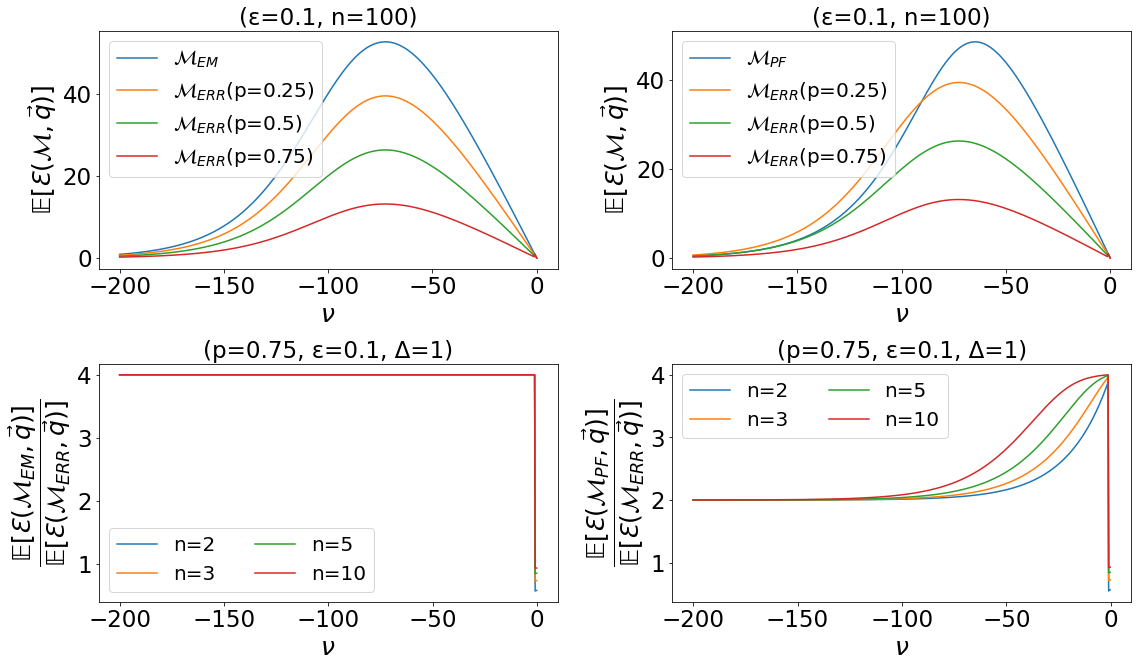

In [420]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values, _p_index, _num_categories_list)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [279]:
_epsilon = 1
_sensitivity = 1
_num_categories = 5
_num_categories_list = [2, 3, 5, 10, 100, 1000]
_c_vector = np.arange(-20,0.25,0.25)
_p_values = [0.25, 0.5, 0.75]
_p_index = 2

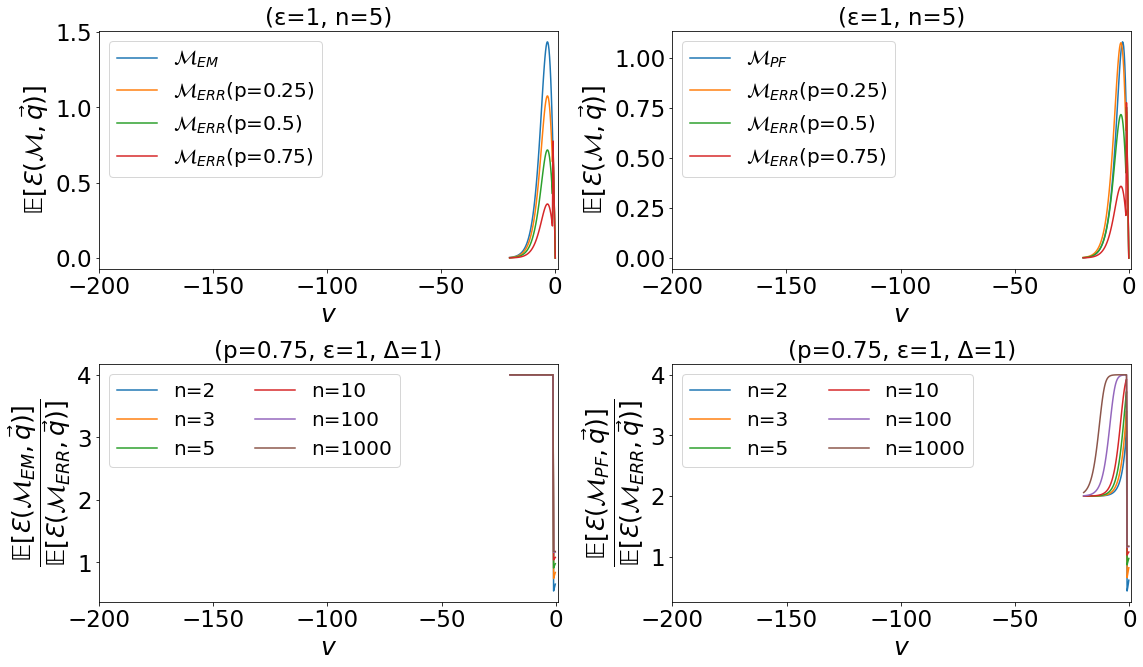

In [280]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values, _p_index, _num_categories_list)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [274]:
_epsilon = 10
_sensitivity = 1
_num_categories = 10
_num_categories_list = [2, 3, 5, 10, 100, 1000]
_c_vector = np.arange(-2,0.1,0.1)
_p_values = [0.25, 0.5, 0.75]
_p_index = 2

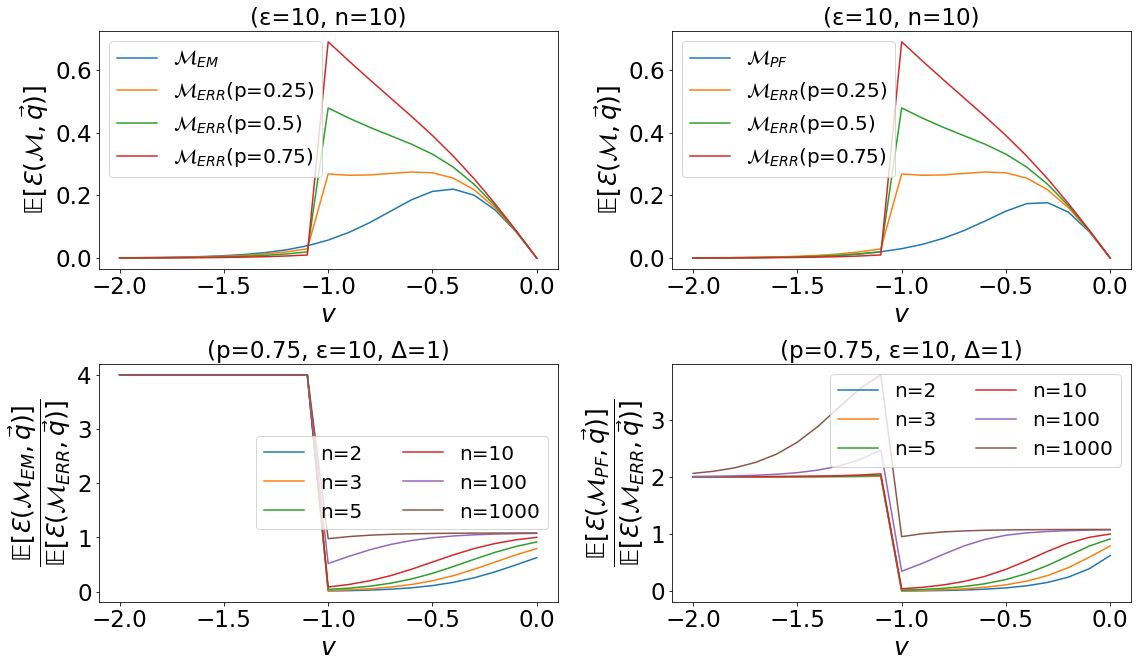

In [275]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values, _p_index, _num_categories_list)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [334]:
def plotting_worst_case_error(epsilon, sensitivity, max_expected_errors_dict, max_num_categories):
    r"""
    Plots the results of the experiments about worst-case error.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    max_num_categories: int
        The experiments will be carried out from having 2 to max_num_categories categories
        
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    case: int, optional
        It is eaither best or worst case scneario within the worst case scenario
    """      
    n = np.arange(2, max_num_categories, 1)
    
    fig, axs = plt.subplots()
    
    for key, max_expected_errors in max_expected_errors_dict.items():
        
        c = next(color)
        if key == r'$\dfrac{Δ}{2ε}log(n)$' or key == r'$\dfrac{2Δ}{ε}log(n)$' or key == r'$\mathcal{M}_{ERR}$' + '(p={})'.format(1):
            
            axs.plot(n, max_expected_errors, '--', label=key, c=c)
            continue
            
        axs.plot(n, max_expected_errors, label=key)#, c=c)
    axs.set_title('(\u03B5={}, \u0394={})'.format(epsilon, sensitivity), fontsize='xx-large')
        
    axs.set(xlabel='n', ylabel='Worst-Case Expected Error')
    
    axs.xaxis.get_label().set_fontsize('xx-large')
    axs.yaxis.get_label().set_fontsize('xx-large')
    axs.tick_params(axis='x', labelsize='x-large')
    axs.tick_params(axis='y', labelsize='x-large')
    
    plt.legend(loc=4, ncol=3, prop={'size': 8})
    #plt.legend(loc=(-0.15, -0.55), ncol=4) 
    plt.yscale('log')
    plt.xscale('log')
    
    if epsilon >= 1:
        plt.savefig("Figures/zz_Bounded_worst_case_expected_error_analysis.pdf", bbox_inches='tight')
    else:
        plt.savefig("Figures/zz_Bounded_worst_case_expected_error_analysis_low_eps.pdf", bbox_inches='tight')
    plt.show()
    

In [172]:
def function_for_maximizing_worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, c, num_categories, p):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    It is a modification of equation 7 of the publication found:  https://arxiv.org/abs/2010.12603, so that
    it adapts to enhanced randomized response.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float
        Heads probability in randomized response
        
    num_true_categories: int
        Number of categories that are in the bounding interval
    """  
    worst_case_probability = np.exp(epsilon * c / 2 / sensitivity)
    if abs(c) > sensitivity:
        return (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    else:
        a = (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
        b = (2 * sensitivity / epsilon) * (p/num_categories) * (num_categories - 1) * np.log(1/worst_case_probability)
        return a + b 

In [173]:
def maximize_expected_error_function(expected_error_calculation, num_categories, epsilon, sensitivity, p=0):    
    r"""
    Maximizes the probability (x-value) of the worst-case expected error function
    
    Parameters
    ----------
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p: float, optional
        Heads probability in randomized response
    """            
    # We multiuply by -1 nso that we find the maximum and not the minimum
    worst_case_probability = -minimize_scalar(lambda c: -expected_error_calculation(epsilon, sensitivity, c, num_categories, p), bounds=(0,1), method='bounded').fun
    return worst_case_probability 


In [190]:
def worst_case_error_analysis(max_num_categories, epsilon, c_vector, sensitivity, p_values):
    r"""
    Main fuction that executes the analysis of the worst-case error and plots the results
    
    Parameters
    ----------
    max_num_categories: int
        The experiments will be carried out from having 2 to max_num_categories categories
        
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    case: int
        Takes values 1 or 2 depending on whether it is the best or the worst case
    """       
    max_expected_errors_dict = defaultdict(list)
    
    for n in range(2, max_num_categories):
        
        max_expected_errors_dict[r'$\dfrac{2Δ}{ε}log(n)$'].append((2*sensitivity)/epsilon*np.log(n))
        max_expected_errors_dict[r'$\dfrac{Δ}{2ε}log(n)$'].append((sensitivity)/(2*epsilon)*np.log(n))
        max_expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(maximize_expected_error_function(worst_case_expected_error_exponential_mechanism, n, epsilon, sensitivity))
        max_expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(maximize_expected_error_function(worst_case_expected_error_permute_and_flip, n, epsilon, sensitivity))
        
        
        
        for p in p_values:              
#             max_expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(maximize_expected_error_function(function_for_maximizing_worst_case_expected_error_enhanced_randomised_response, n, epsilon, sensitivity, p))
            temp_list_expected_errors_ERR = []
            for c in c_vector:

                if abs(c) <= sensitivity:
                    num_true_categories = n
                else:
                    num_true_categories = 1

                worst_case_probability = np.exp(epsilon * c / 2 / sensitivity)

                temp_list_expected_errors_ERR.append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, n, p, num_true_categories))
#             print(n, p, max(temp_list_expected_errors_ERR))
            max_expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(max(temp_list_expected_errors_ERR))

    
    plotting_worst_case_error(epsilon, sensitivity, max_expected_errors_dict, max_num_categories)
    
    

In [326]:
_epsilon = 1
_sensitivity = 1
_num_categories = 50
_num_categories_list = [2, 3, 5, 10, 100, 1000]
_c_vector = np.arange(-20,0.25,0.25)
_p_values = [0.25, 0.5, 0.75]
_p_index = 2

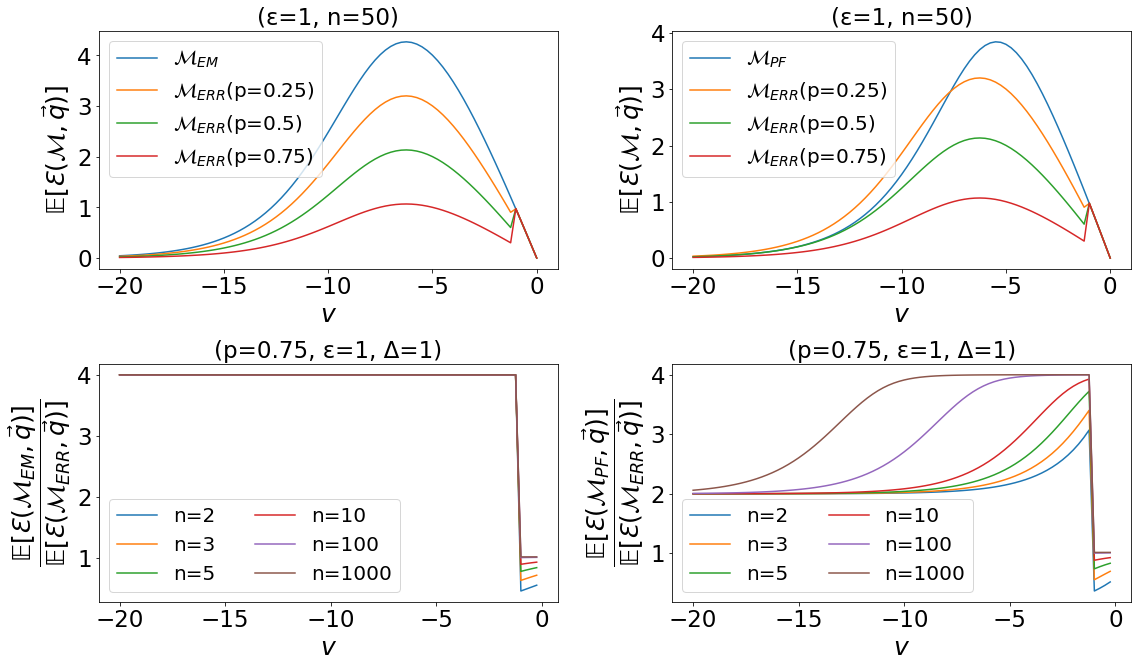

In [327]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values, _p_index, _num_categories_list)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [335]:
# Independent variables
_epsilon = 1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75]
_c_vector = np.arange(-200,1,1)
_max_num_categories = 10000
# For epsilon=1, bBefore 0.33=p, all have a jump - recommend p>1/3. This is due to the change of maximum in the 2-piece function, the maximum is different
# for higher ps, this happens later but because the error is 

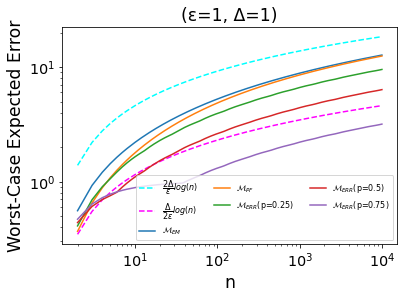

In [336]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _c_vector, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [337]:
_epsilon = 0.1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75]
_c_vector = np.arange(-200,1,1)
_max_num_categories = 10000

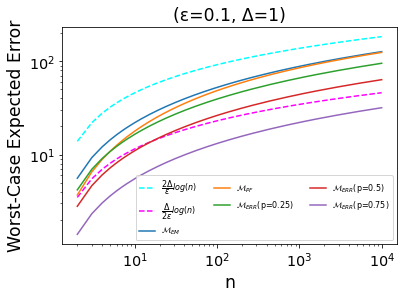

In [338]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _c_vector, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [245]:
_epsilon = 0.1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75, 0.9]
_c_vector = np.arange(-200,1,1)
_max_num_categories = 10000

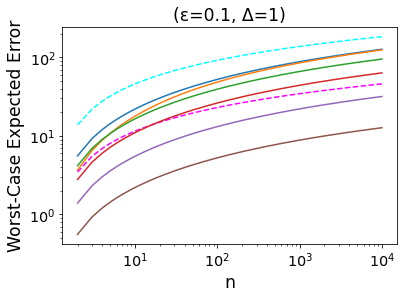

In [246]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _c_vector, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [247]:
_epsilon = 1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75, 0.9]
_c_vector = np.arange(-200,1,1)
_max_num_categories = 10000

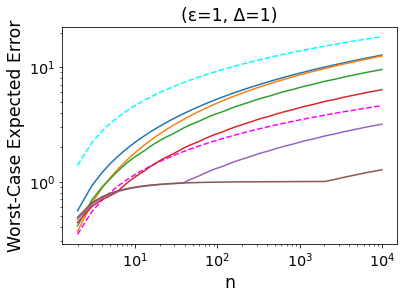

In [248]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _c_vector, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [253]:
_epsilon = 10
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75, 0.9]
_c_vector = np.arange(-200,1,1)
_max_num_categories = 100

<ipython-input-2-8543345e9dd7>:89: RuntimeWarning: overflow encountered in double_scalars
  a = (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
<ipython-input-2-8543345e9dd7>:90: RuntimeWarning: overflow encountered in double_scalars
  b = (2 * sensitivity / epsilon) * (p/num_true_categories) * (num_true_categories - 1) * np.log(1/worst_case_probability)


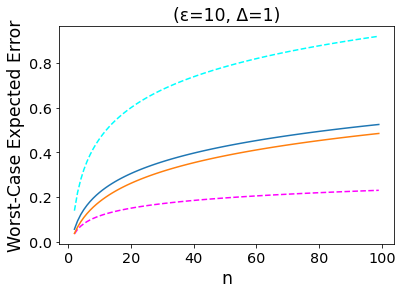

In [254]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _c_vector, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [8]:
from random import seed
from random import random

In [50]:
a = []
max_num_categories = 100000
a.append(max_num_categories)
for _ in range(1, max_num_categories+1):
    a.append(round(random()*(max_num_categories-2)))

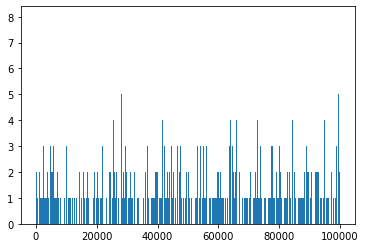

In [52]:
plt.hist(a, bins=100000)  # density=False would make counts
plt.show()